<a href="https://colab.research.google.com/github/palkakrzysiek/trainings-generator-python/blob/main/progression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Plugin to upload/download workouts
https://chrome.google.com/webstore/detail/share-your-garmin-connect/kdpolhnlnkengkmfncjdbfdehglepmff

In [19]:
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
import pandas as pd
import re

In [20]:

def warm_up(time, step_order):
    return {
        "type": "ExecutableStepDTO",
        "stepId": 2698638070,
        "stepOrder": step_order,
        "stepType": {
            "stepTypeId": 1,
            "stepTypeKey": "warmup",
            "displayOrder": 1
        },
        "description": "Easy",
        "endCondition": {
            "conditionTypeId": 2,
            "conditionTypeKey": "time",
            "displayOrder": 2,
            "displayable": True
        },
        "endConditionValue": time,
        "targetType": {
            "workoutTargetTypeId": 1,
            "workoutTargetTypeKey": "no.target",
            "displayOrder": 1
        }
    }


def run(distance, min_speed_mps, max_speed_mps, description, step_order):
    return {
        "type": "ExecutableStepDTO",
        "stepId": 2698638071 + step_order,
        "stepOrder": step_order,
        "stepType": {
            "stepTypeId": 3,
            "stepTypeKey": "interval",
            "displayOrder": 3
        },
        "description": description,
        "endCondition": {
            "conditionTypeId": 3,
            "conditionTypeKey": "distance",
            "displayOrder": 3,
            "displayable": True
        },
        "endConditionValue": distance,
        "preferredEndConditionUnit": {
            "unitId": 2,
            "unitKey": "kilometer",
            "factor": 100000
        },
        "targetType": {
            "workoutTargetTypeId": 6,
            "workoutTargetTypeKey": "pace.zone",
            "displayOrder": 6
        },
        "targetValueOne": min_speed_mps,
        "targetValueTwo": max_speed_mps
    }

In [21]:
def workout_template(name, description, steps, estimated_duration_in_secs, estimated_distance_in_meters):
    return {
    "workoutId": 388473607,
    "ownerId": 66888980,
    "workoutName": name,
    "description": description,
    "updatedDate": "2021-09-12T14:08:55.0",
    "createdDate": "2021-09-12T14:08:55.0",
    "sportType": {
        "sportTypeId": 1,
        "sportTypeKey": "running",
        "displayOrder": 1
    },
    "estimatedDurationInSecs": estimated_duration_in_secs,
    "estimatedDistanceInMeters": estimated_distance_in_meters,
    "workoutSegments": [
        {
            "segmentOrder": 1,
            "sportType": {
                "sportTypeId": 1,
                "sportTypeKey": "running",
                "displayOrder": 1
            },
            "workoutSteps": steps
        }
    ],
    "shared": False
}

def minpkm_to_mps(val):
    return 1000 / val / 60


def format_secs(value):
    h = int(value / 60 / 60)
    m = int((value / 60) % 60)
    s = int(value % 60)
    if h > 0:
        return "{:d}:{:02d}:{:02d}".format(h,m,s)
    else:
        return "{:02d}:{:02d}".format(m,s)


def format_pace(mpkm):
    min = int(mpkm)
    sec = int((mpkm % 1) * 60)
    return "{:d}:{:02d}".format(min, sec)


def format_meters_to_km(meters):
    return "{:.2f}".format(meters/1000.0)

def format_meters_to_km_short(meters):
    return re.sub(r"\.?0+$", "", format_meters_to_km(meters))

# %matplotlib notebook
def plot_splits(df):

    print(df)

    plt.clf()
    plt.close('all')

    plt.rcParams["figure.figsize"] = (10,10)

    ax = df.plot.line(x='covered_distance', y=['min_pace', 'max_pace'], stacked=False, color={'min_pace':'#63edff', 'max_pace':'#ffc859'}, linewidth=1)

    ax = df.plot.line(x='covered_distance', y=['pace'], stacked=False, color={'pace':'#006e1d'}, linewidth=0, markersize=6 , marker='o', grid=True, ax=ax)


    plt.xlim(0, df['covered_distance'].max() + 0.2)
    plt.ylim(max(0, df['max_pace'].min() - .2), df['min_pace'].max() + .2)

    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(3))
    ax.xaxis.set_major_locator(MultipleLocator(500))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')

    ax.fill_between(df['covered_distance'], df['min_pace'], df['pace'], color='#63edff')

    ax.fill_between(df['covered_distance'], df['max_pace'], df['pace'], color='#ffc859')

    plt.draw() # needed to recalculate labels values
    ax.set_xticklabels([ format_meters_to_km_short(float(x.get_text().replace('−', '-'))) for x in ax.get_xticklabels()])
    ax.set_yticklabels([ format_pace(float(y.get_text().replace('−', '-'))) for y in ax.get_yticklabels()])




    plt.show()



def progression_df( target_distance, split_distance, start_pace_minpkm, end_pace_minpkm, pace_toleration):

    splits_number = int(target_distance/split_distance)
    total_distance = split_distance * splits_number

    slope = (end_pace_minpkm - start_pace_minpkm) / (total_distance - split_distance)
    # - split_distance to have the last split at end disntance

    x = np.arange(0, total_distance, split_distance)
    y = start_pace_minpkm + slope * x

    df = pd.DataFrame(np.array([x, y]).transpose(), columns=['covered_distance', 'pace'])

    df['min_pace'] = df['pace'] + pace_toleration
    df['max_pace'] = df['pace'] - pace_toleration

    df['min_speed_mps'] = df['min_pace'].apply(minpkm_to_mps)
    df['max_speed_mps'] = df['max_pace'].apply(minpkm_to_mps)

    df['split_distance'] = split_distance

    return df

def format_steps(df):

    df['mps'] = 1000 / df['pace'] / 60

    df['lap'] = df.index + 1

    df['lap_time_sec'] = df['split_distance'] / df['mps']

    df['total_time'] = df['lap_time_sec'].cumsum()

    df['time_left'] = df['total_time'].values[::-1]

    df['formatted_time_left'] = df['time_left'].apply(format_secs)

    df['laps_left'] = range(len(df), 0, -1)

    df['formatted_pace'] = df['pace'].apply(format_pace)

    total_distance = df['split_distance'].sum()

    df['distance_left'] = total_distance - df['covered_distance']

    df['formatted_distance_left'] = df['distance_left'].apply(lambda dis: format_meters_to_km(dis))


    df['formatted_min_pace'] = df['min_pace'].apply(format_pace)
    df['formatted_max_pace'] = df['max_pace'].apply(format_pace)

    df['split_time'] = df['split_distance'] / df['mps']

    df['description'] = df.apply(lambda row: ">{:s}< | {:d} lap | {:s} | {:s}km".format(row['formatted_pace'], row['laps_left'], row['formatted_time_left'], row['formatted_distance_left']), axis=1)

    return df

In [22]:
def progression(progressions):

    #  target_distance, split_distance, start_pace_minpkm, end_pace_minpkm, pace_toleration
    dfs = map(lambda p: progression_df(
        p["target_distance"],
        p["split_distance"],
        p["start_pace_minpkm"],
        p["end_pace_minpkm"],
        p["pace_toleration"],
    ), progressions)


    df = pd.concat(dfs).sort_index(kind='merge')
    df.reset_index(drop=True, inplace=True)
    df['covered_distance'] = df['split_distance'].shift(periods=1, fill_value=0).cumsum() # needs to be adjusted after merging

    plot_splits(df)


    df = format_steps(df)

    print(df)

    steps = list(df.apply(lambda row: run(distance=row['split_distance'], min_speed_mps=row['min_speed_mps'], max_speed_mps=row['max_speed_mps'], description=row['description'], step_order=row['lap'] + 1), axis=1).values)

    steps.insert(0, warm_up(
        time=120,
        step_order=1
    ))

    total_distance = int(df['split_distance'].sum())

    print(steps)

    intervals_num = len(progressions)


    def splits_number(defintion):
        return int(defintion["target_distance"] / defintion["split_distance"])

    # if intervals_num == 1:
    #     p = progressions[0]
    #     name = "{:s}km {:s}>{:s}".format(format_meters_to_km_short(total_distance), format_pace(p["start_pace_minpkm"]), format_pace(p["end_pace_minpkm"]))
    #     description = str(p["split_distance"]) + "m * " + str(splits_number(p)) + " splits, est. time " + df['formatted_time_left'][0]
    # else:
    splits_paces = "+".join(list(map(lambda s:
                                      format_pace(s["start_pace_minpkm"]) + ">" + format_pace(s["end_pace_minpkm"])
                                      , progressions)))
    name = "{:s}km {:s}".format(format_meters_to_km_short(total_distance), splits_paces)
    if intervals_num > 1:
        name += " interval"
    splits_desc = " + ".join(list(map(lambda s:
                                       str(s["split_distance"]) +
                                       "m * " + str(splits_number(s)) + " " +
                                       format_pace(s["start_pace_minpkm"]) + "->" + format_pace(s["end_pace_minpkm"])
                                       , progressions)))
    description = splits_desc + " | est. time " + df['formatted_time_left'][0]


    print(name)
    print(description)

    est_time_sec = int(df['time_left'][0])

    return workout_template(
        name=name,
        description=description,
        steps=steps,
        estimated_duration_in_secs=est_time_sec,
        estimated_distance_in_meters=total_distance
    )

In [23]:
# splits = 16
# workout = progression([
#     {
#         "target_distance": 750 * splits,
#         "split_distance": 750,
#         "start_pace_minpkm": 7.5,
#         "end_pace_minpkm": 6.5,
#         "pace_toleration": 0.33334
#     },
#     {
#         "target_distance": 250 * splits,
#         "split_distance": 250,
#         "start_pace_minpkm": 6.5,
#         "end_pace_minpkm": 5.5,
#         "pace_toleration": 0.66667
#     }
# ])
#

# json.dumps(workout)

    covered_distance      pace  min_pace  max_pace  min_speed_mps  \
0                  0  7.500000  8.000000  7.000000       2.083333   
1                400  5.500000  6.500000  4.500000       2.564103   
2                550  7.388889  7.888889  6.888889       2.112676   
3                950  5.388889  6.388889  4.388889       2.608696   
4               1100  7.277778  7.777778  6.777778       2.142857   
5               1500  5.277778  6.277778  4.277778       2.654867   
6               1650  7.166667  7.666667  6.666667       2.173913   
7               2050  5.166667  6.166667  4.166667       2.702703   
8               2200  7.055556  7.555556  6.555556       2.205882   
9               2600  5.055556  6.055556  4.055556       2.752294   
10              2750  6.944444  7.444444  6.444444       2.238806   
11              3150  4.944444  5.944444  3.944444       2.803738   
12              3300  6.833333  7.333333  6.333333       2.272727   
13              3700  4.833333  5.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator


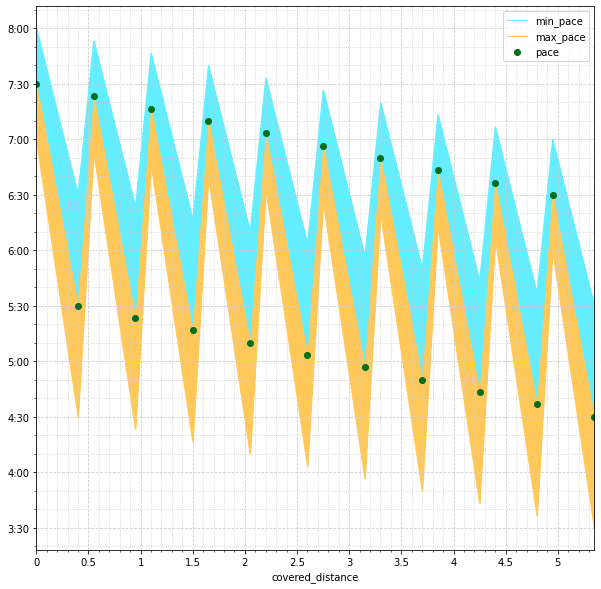

    covered_distance      pace  min_pace  max_pace  min_speed_mps  \
0                  0  7.500000  8.000000  7.000000       2.083333   
1                400  5.500000  6.500000  4.500000       2.564103   
2                550  7.388889  7.888889  6.888889       2.112676   
3                950  5.388889  6.388889  4.388889       2.608696   
4               1100  7.277778  7.777778  6.777778       2.142857   
5               1500  5.277778  6.277778  4.277778       2.654867   
6               1650  7.166667  7.666667  6.666667       2.173913   
7               2050  5.166667  6.166667  4.166667       2.702703   
8               2200  7.055556  7.555556  6.555556       2.205882   
9               2600  5.055556  6.055556  4.055556       2.752294   
10              2750  6.944444  7.444444  6.444444       2.238806   
11              3150  4.944444  5.944444  3.944444       2.803738   
12              3300  6.833333  7.333333  6.333333       2.272727   
13              3700  4.833333  5.

In [24]:

splits = 10
workout = progression([
    {
        "target_distance": 400 * splits,
        "split_distance": 400,
        "start_pace_minpkm": 7.5,
        "end_pace_minpkm": 6.5,
        "pace_toleration": 0.5
    },
    {
        "target_distance": 150 * splits,
        "split_distance": 150,
        "start_pace_minpkm": 5.5,
        "end_pace_minpkm": 4.5,
        "pace_toleration": 1
    }
])

In [25]:
import os

with open(os.getenv("HOME") + "/Downloads/" + workout["workoutName"] + '.json', 'w') as f:
    json.dump(workout, f)
